In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
import nltk
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.manifold import TSNE

# Loading Data

In [2]:
data = pd.read_csv('QueryResults.csv')
data = data.set_index('Id')

In [3]:
data.head()

,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
Id,,,,,,,,,,,,,,,,,,,,,
56433394,1,56433462,NaN,2019-06-03 19:23:03,NaN,-1,34,<p>The below code only seems to work on the fi...,11162483.0,NaN,...,2019-06-03 20:23:16,2019-06-03 22:47:37,Macro only running through first result,<excel><vba>,1,2,NaN,2019-06-03 22:45:47,NaN,CC BY-SA 4.0
56448457,1,56448528,NaN,2019-06-04 17:08:03,NaN,-2,142,<p>I have two questions:</p>\n\n<ol>\n<li><p>I...,7057642.0,NaN,...,2019-06-04 21:07:06,2019-07-04 19:20:20,Set limitation on gap tolerance and run time,<csv><optimization><runtime><cplex><ibm-ilog-opl>,1,0,NaN,2019-06-05 02:12:22,NaN,CC BY-SA 4.0
48320518,1,48321008,NaN,2018-01-18 11:42:36,NaN,0,595,<p>I am trying to connect Sql server and MySql...,7428446.0,NaN,...,2018-01-18 12:13:28,2018-01-18 13:53:02,Connect two different Database with one applic...,<mysql><.net><sql-server>,1,3,NaN,2018-01-18 15:21:45,NaN,CC BY-SA 3.0
48320543,1,48320722,NaN,2018-01-18 11:44:25,NaN,4,5737,"<p>I use angular 2 and bootstrap 4, There is a...",2803344.0,NaN,...,NaN,2019-09-24 05:33:43,bootstrap 4 navbar disappears when resizing sc...,<html><angular><bootstrap-4>,3,0,NaN,2018-03-16 19:35:06,NaN,CC BY-SA 3.0
48320558,1,48321030,NaN,2018-01-18 11:44:57,NaN,0,196,<p>I have a xml generated from SharePoint and ...,777551.0,NaN,...,NaN,2018-01-18 12:10:25,xml transform XSLT with namespaces,<xml><xslt>,1,0,NaN,2018-01-18 16:35:29,NaN,CC BY-SA 3.0


Let's take only values that have a score >= 0 to be sure we don't have bad question (implying bad key words)

In [4]:
data = data[data['Score'] >= 0]

# Working on the tags

## Cleaning

In [5]:
tags = data[['Tags']].copy()
# Let's first remplace the '<'
tags['Tags'].replace('<', '', regex=True, inplace=True)

# We then split with pattern '>'
tags['preprocessedTags'] = tags['Tags'].str.split(pat='>')
tags['Tags_'] = [' '.join(map(str, l)) for l in tags["preprocessedTags"]]

## Analysis

Let's first analyse the tags, see the repartition of nbr of tags per question, and the number of unique tags

In [6]:
tagsAnalysis = tags.copy()
tagsAnalysis['Tags'] = [' '.join(map(str, l)) for l in tagsAnalysis["preprocessedTags"]]
tagsAnalysis["tag_count"] = tagsAnalysis["Tags"].apply(lambda x : len(x.split()))

In [7]:
print( "Maximum number of tags in a question: ", tagsAnalysis["tag_count"].max())
print( "Minimum number of tags in a question: ", tagsAnalysis["tag_count"].min())
print( "Average number of tags in a question: ", tagsAnalysis["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.7814688508617014


[]

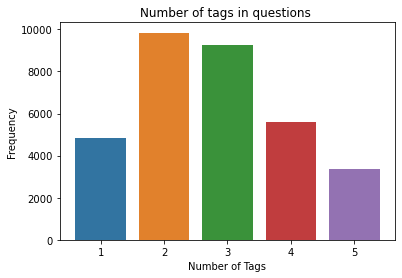

In [8]:
sns.countplot(tagsAnalysis["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.plot()

Let's see how many unique tags we have in our DataFrame

In [9]:
uniqueTags = [item for sublist in tagsAnalysis['preprocessedTags'] for item in sublist]
multipleTags = uniqueTags.copy()
uniqueTags = list(dict.fromkeys(uniqueTags))
uniqueTags.remove('')
print("Number of unique tags: ",len(uniqueTags))

Number of unique tags:  7990


In [10]:
multipleTags_df = pd.DataFrame(multipleTags, columns=['Tags'])
multipleTags_df = multipleTags_df[multipleTags_df['Tags'] != '']
multipleTags_df['Count'] = 1
multipleTags_df = multipleTags_df.groupby('Tags').count()

In [11]:
multipleTags_sorted = multipleTags_df.sort_values(by='Count', ascending=False)
multipleTags_sorted.head()

,Count
Tags,
python,5297
javascript,4419
java,3366
html,2214
c#,2094


As there is many tags that appears only few times, let's see how much we have that appears more than 30 times

In [12]:
print("Number of tags that appears more than 30 times: ", len(multipleTags_df[multipleTags_df['Count'] > 30]))

Number of tags that appears more than 30 times:  341


Let's see the 20 most common tags

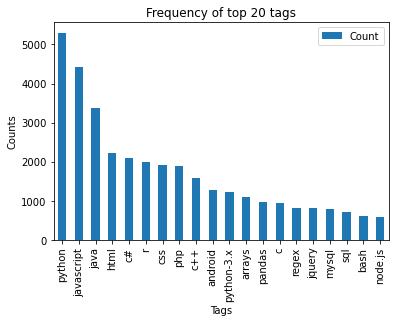

In [13]:
i=np.arange(20)
multipleTags_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, multipleTags_sorted.index)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

## Keeping only the common tags for modeling

The goal of this section is to clean the tags inside the Dataset ; We'll keep only the tags that appears more than 30 times

In [14]:
tagsToKeep = multipleTags_df[multipleTags_df['Count'] > 30].reset_index().drop(columns=['Count'])['Tags']

In [15]:
# First we merge the preprocessedTags into the main df
dataTags = pd.merge(data, tags, left_index=True, right_index=True, how='inner')

In [16]:
# Then we keep only the question where one of the tagsToKeep is in
realTags = []
for ind in dataTags['preprocessedTags']:
    t = []
    for val in ind:
        if val in tagsToKeep.values:
            t.append(val)
    realTags.append(t)
    
realTags = pd.DataFrame({"preprocessedTags": realTags})
realTags.index = dataTags.index

In [18]:
dataTags = dataTags.drop(columns=['preprocessedTags'])
dataTags = pd.merge(dataTags, realTags, left_index=True, right_index=True, how='inner')

In [19]:
preprocessed_df = dataTags[['Body', 'Tags_']]

In [20]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags_'])

In [21]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [22]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

In [23]:
print(questions_covered[2],"% of questions covered by 300 tags")
print("Number of questions that are not covered by 300 tags : ", questions_covered_fn(300),"out of ", total_qus)

96.334 % of questions covered by 300 tags
Number of questions that are not covered by 300 tags :  1204 out of  32842


# Description

## Cleaning

In [24]:
description = dataTags[['Title','Body']].copy()
# Let's add the title to the body
description['Body'] = description[['Title','Body']].apply(lambda x: ' '.join(x), axis=1)
description['Body'] = description[['Title','Body']].apply(lambda x: ' '.join(x), axis=1)
description = description[['Body']]

In [25]:
description['Body']

Id
48320518    Connect two different Database with one applic...
48320543    bootstrap 4 navbar disappears when resizing sc...
48320558    xml transform XSLT with namespaces xml transfo...
48320572    Convert Timestamp to Date with various formats...
44247       What is the best practice for estimating requi...
                                  ...                        
63450818    transform data frame using tidyr transform dat...
63444953    VSCode Prettier not formatting CSS VSCode Pret...
63445069    What are effects on overhead of using list.pop...
63445277    Best way to think about implementing recursive...
63442899    Pandas - Trying to assign values to dataframe ...
Name: Body, Length: 32842, dtype: object

### HTML tags

In [26]:
parser = lambda x: html.fromstring(x).text_content()
description['Body_Cleaned'] = list(map(parser, description['Body']))
description['Body_Cleaned'].replace(r'\n', '', regex=True, inplace=True)
# There is still some html tags, let's remove them with a regex
TAG_RE = re.compile(r'<[^>]+>')
tags_re = lambda x: TAG_RE.sub('', x)
description['Body_Cleaned'] = list(map(tags_re, description['Body_Cleaned']))

In [27]:
description = description.drop(columns=['Body'])

### Normalisation

The goal here is to extract the frequences of the words

In [28]:
data_cleaned = pd.merge(dataTags, description, left_index=True, right_index=True, how='inner')
data_cleaned = data_cleaned[['Title', 'Body_Cleaned', 'preprocessedTags']]

In [29]:
data_cleaned.head()

,Title,Body_Cleaned,preprocessedTags
Id,,,
48320518,Connect two different Database with one applic...,Connect two different Database with one applic...,"[mysql, .net, sql-server]"
48320543,bootstrap 4 navbar disappears when resizing sc...,bootstrap 4 navbar disappears when resizing sc...,"[html, angular, bootstrap-4]"
48320558,xml transform XSLT with namespaces,xml transform XSLT with namespaces xml transfo...,[xml]
48320572,Convert Timestamp to Date with various formats...,Convert Timestamp to Date with various formats...,"[ios, json, date, datetime]"
44247,What is the best practice for estimating requi...,What is the best practice for estimating requi...,[project-management]


### Stop Words

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mlmaster/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# First we get the freq of words on our dataset
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_cleaned.index:
    desc[i] += tokenizer.tokenize(data_cleaned.loc[i, 'Body_Cleaned'].lower())
    
stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

In [32]:
freq_totale = nltk.Counter()
for k, v in zip(desc.keys(), desc.values()):
    freq_totale += freq[k]

In [33]:
freq_totale_sorted = pd.DataFrame.from_dict(freq_totale, orient='index').sort_values(by=0, ascending=False)
freq_totale_sorted = freq_totale_sorted[freq_totale_sorted[0] <= 18000]

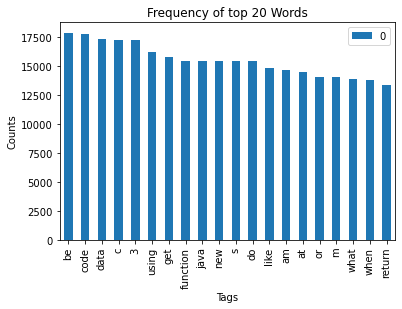

In [34]:
i=np.arange(20)
freq_totale_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 Words')
plt.xticks(i, freq_totale_sorted.index)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [35]:
# Here is our list of stop words
to_keep = { key:value for (key,value) in freq_totale.items() if value <= 18000 and value >= 50}.keys()
# Let's add the common stop words list of nltk
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

In [36]:
len({ key:value for (key,value) in freq_totale.items() if value > 10000 and value < 50})

0

In [37]:
len(to_keep)

5473

Let's clean the words in our description

In [38]:
stemmer = EnglishStemmer()

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = []
i = 0
for index, row in data_cleaned.iterrows():
    if i%2000 == 0:
        print("Performing Step ", i, "/", data_cleaned.shape[0])
    token = tokenizer.tokenize(row['Body_Cleaned'].lower())
    description = [stemmer.stem(w) for w in token if not w in list(sw) and w in list(to_keep)]
    desc.append(description)
    i += 1

Performing Step  0 / 32842
Performing Step  2000 / 32842
Performing Step  4000 / 32842
Performing Step  6000 / 32842
Performing Step  8000 / 32842
Performing Step  10000 / 32842
Performing Step  12000 / 32842
Performing Step  14000 / 32842
Performing Step  16000 / 32842
Performing Step  18000 / 32842
Performing Step  20000 / 32842
Performing Step  22000 / 32842
Performing Step  24000 / 32842
Performing Step  26000 / 32842
Performing Step  28000 / 32842
Performing Step  30000 / 32842
Performing Step  32000 / 32842


In [39]:
data_cleaned['desc'] = [' '.join(map(str, l)) for l in desc]

In [40]:
data_cleaned = data_cleaned[['desc', 'preprocessedTags']]
tags = pd.DataFrame(data_cleaned.preprocessedTags.tolist(),
                    columns=['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'],
                    index=data_cleaned.index)
data_cleaned = pd.merge(data_cleaned, tags, left_index=True, right_index=True, how='inner')

# Saving data

In [41]:
import csv
to_keep_list = list(to_keep)
with open("Flask/to_keep.csv", 'w') as fp:
    wr = csv.writer(fp, quoting=csv.QUOTE_ALL)
    wr.writerow(to_keep_list)

sw_list = list(sw)
with open("Flask/sw.csv", 'w') as fp:
    wr = csv.writer(fp, quoting=csv.QUOTE_ALL)
    wr.writerow(sw_list)

In [42]:
data_cleaned.to_csv('data_cleaned.csv')